In [98]:
import re, numpy as np, pandas as pd
from transformers import BertTokenizer, BertPreTrainedModel, BertModel,BertConfig,BertForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn
import torch
import matplotlib.pyplot as plt
import math

In [2]:
class BertForTokenClassification(BertPreTrainedModel):
    
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
    ):
    
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )





In [3]:
tag2idx ={'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 
'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16, 'PAD': 17}

In [4]:
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True,input_ids=True,output_attentions=True)
model = BertModel.from_pretrained('bert-base-uncased',config=config) #pre-trained
#NER 
model_token =  BertForTokenClassification.from_pretrained(
    "bert-base-uncased",num_labels=len(tag2idx))
model_token = torch.load('NER2', map_location={'cuda:0': 'cpu'})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bia

In [5]:
# how many data we use
data_count = 10

# read the sentiment sample
sentiment_train = pd.read_csv("attention1.csv")

# extract the 'sentiment' column to compare what's different between 0(negative) and 1(positive)
sentiment_class = sentiment_train.loc[0:data_count,"sentiment"]


In [6]:
# put the first 10 samples into tokenizer
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')
inputs_base = [0]*data_count
outputs_base = [0]*data_count

for i in range(data_count):
    text = str(sentiment_train.loc[i,'Sentiment'])
    inputs_base[i] = tokenizer_base(text, return_tensors="pt")
    outputs_base[i] = model(**inputs_base[i])

In [64]:
# outputs[i]     -> the i-th data i get
#        [0~3]   -> 0:n個詞的vector, 1:attention的vector, 2: hidden的vector, 3:attention對於每一層中每個字和上一個字的分布情況
#        [0~12]  -> 如果使用hidden和attention，則此層代表訓練模型中的第幾層
#        [0]     -> batch count
#        [0~n-1] -> 第幾個字
#        [0~767] -> 第幾維詞向量

# outputs[i][2][12][0][0]: 第i組data其第12層hidden state的[CLS]
output_attention_base = [0]*data_count
for i in range(data_count):
    output_attention_base[i] = outputs_base[i].attentions
output_attention_base[1][0].shape

torch.Size([1, 12, 345, 345])

In [75]:
# base
# attention_base[data][layer][length]
attention_base = [0]*data_count

for data in range(data_count):
    count = output_attention_base[data][0][0][0][0].size(dim=0)
    attention_base[data] = [0]*12
    for layer in range(12):
        attention_base[data][layer] = [0]*count
        #for i in range(count):      # which word
        for j in range(count):  # to which word
            for k in range(12): # attention head
                attention_base[data][layer][j] += output_attention_base[data][layer][0][k][count-1][j].item()
            attention_base[data][layer][j] /= 12



In [79]:
len(attention_base[0])

12

In [80]:
len(attention_base[0][0])

207

In [9]:
config2 = BertConfig.from_pretrained("bert-large-uncased", output_hidden_states=True,input_ids=True,output_attentions=True)
model2 = BertModel.from_pretrained('bert-large-uncased',config=config2) #pre-trained
#NER 
model2_token =  BertForTokenClassification.from_pretrained(
    "bert-large-uncased",num_labels=len(tag2idx))
model2_token = torch.load('NER2', map_location={'cuda:0': 'cpu'})

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.b

In [10]:
# put the first 10 samples into tokenizer
tokenizer_large = BertTokenizer.from_pretrained('bert-large-uncased')
inputs_large = [0]*data_count
outputs_large = [0]*data_count

for i in range(data_count):
    text = str(sentiment_train.loc[i,'Sentiment'])
    inputs_large[i] = tokenizer_large(text, return_tensors="pt")
    outputs_large[i] = model2(**inputs_large[i])

In [11]:
# outputs[i]     -> the i-th data i get
#        [0~3]   -> 0:n個詞的vector, 1:attention的vector, 2: hidden的vector, 3:attention對於每一層中每個字和上一個字的分布情況
#        [0~12]  -> 如果使用hidden，則此層代表訓練模型中的第幾層，沒有使用則忽略此層
#        [0]     -> 目前還不知道有甚麼用...
#        [0~n-1] -> 第幾個字
#        [0~767] -> 第幾維詞向量

# outputs[i][2][12][0][0]: 第i組data其第12層hidden state的[CLS]
output_attention_large = [0]*data_count
for i in range(data_count):
    output_attention_large[i] = outputs_large[i].attentions
output_attention_large[1][0][0].shape

torch.Size([16, 345, 345])

In [39]:
outputs_large[0][2][24].shape

torch.Size([1, 207, 1024])

In [86]:
# base
# attention_base[data][layer][length]
attention_large = [0]*data_count

for data in range(data_count):
    count = output_attention_large[data][0][0][0][0].size(dim=0)
    attention_large[data] = [0]*24
    for layer in range(24):
        attention_large[data][layer] = [0]*count
        #for i in range(count):      # which word
        for j in range(count):  # to which word
            for k in range(16): # attention head
                attention_large[data][layer][j] += output_attention_large[data][layer][0][k][count-1][j].item()
            attention_large[data][layer][j] /= 16



In [87]:
len(attention_large[0])

24

In [88]:
len(attention_large[0][0])

207

In [110]:
# calculate the Euclidean distance
def EucliDist(A,B):
    return math.sqrt(sum([ (a-b)**2 for (a,b) in zip(A,B) ]))

outputList = [0]*10
for num in range(10):
    outputList[num] = [0]*12
    for i in range(12):
        outputList[num][i] = [0]*24
        for j in range(24):        
            outputList[num][i][j] = EucliDist(attention_base[num][i], attention_large[num][j])


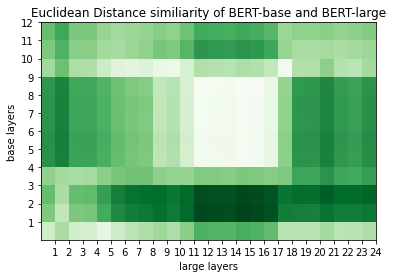

In [111]:
# now draw the heat map
tickX = []
tickY = []
for i in range(1,25):
    tickX.append(i)
    if i < 13:
        tickY.append(i)

for i in range(10):
    plt.xlabel('large layers')
    plt.ylabel('base layers')
    plt.xticks(tickX)
    plt.yticks(tickY)
    plt.title('Euclidean Distance similiarity of BERT-base and BERT-large')
    plt.pcolormesh(outputList[i], cmap='Greens')
    plt.savefig('data'+str(i)+'.jpg')

In [75]:
output_attention_base[1][0][0][0][0].size(dim=0)

345

In [74]:
outputs_base[1][3][0][0][0][0][0].item()

0.003084070747718215